## Visualization of the sample selection bias

In this notebook, we reproduce the Figure 3 of the original [paper](https://arxiv.org/pdf/2310.14814.pdf) that compares the following labeling procedures:
- IID: Draw labeled data uniformly such that the classes are balanced;
- SSB: Apply sample selection bias to label data such that it preserves the original class distribution of the data.




In [2]:
%reload_ext autoreload
%autoreload 2

### Import

In [3]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

sys.path.append("..")
from src.datasets.read_dataset import RealDataSet

custom_params = {"axes.grid": False}
sns.set_theme(style="white", rc=custom_params)
sns.set_context("talk")
plt.rcParams.update({"figure.autolayout": True})

### Plotting functions 

In [4]:
def get_statistics(
    dataset: RealDataSet,
    y_l: np.array,
    y_u: np.array,
    y_test: np.array,
    n_classes: int,
):
    """
    Recover statistics of the dataset.

    Parameters
    ----------
    dataset: RealDataSet
        Instance of RealDataSet class.
    y_l: array, shape = [n_l]
        Labels of training labeled data.
    y_u: array, shape = [n_u]
        Labels of training unlabeled data.
    y_test: array, shape = [n_test]
        Test labels.
    n_classes: int
        Number of classes.
    """
    n = len(dataset.y)
    n_lab = len(y_l)
    n_unlab = len(y_u)
    n_train = n_lab + n_unlab
    n_test = len(y_test)
    n_all = n_train + n_test

    # Print statistics
    if n_all == n:
        print("The split is valid.")
    else:
        print("Invalid split.")
    print(f"Number of data: {n}")
    print(f"Feature dimension: {int(dataset.x.shape[1])}")
    print(f"Number of classes: {n_classes}")
    print(f"Number of labeled training data: {n_lab} ({n_lab / n * 100:.2f}%)")
    print(f"Number of unlabeled training data: {n_unlab} ({n_unlab / n * 100:.2f}%)")
    print(f"Number of test data: {n_test} ({n_test / n * 100:.2f}%) \n")


myplot = lambda x, y, color, alpha, marker, ax, label: ax.scatter(
    x=x,
    y=y,
    s=100,
    edgecolors="k",
    color=color,
    alpha=alpha,
    marker=marker,
    linewidths=1.2,
    label=label,
)


def plot_PC1(
    x_train: np.array,
    labeled_idxes: np.array,
    label_names=["Labeled Training Data", "All Training Data"],
    ax=None,
    figsize=(5, 3),
    show=False,
):
    """
    Plot the distributions of projection values on the
    first principal component (PC1) for the training data and for the labeled traning data.

    Parameters
    ----------
    x_train: array, shape = [n_train]
        Training data.
    labeled_idxes: list of length n_l
        Indexes of training data to include in labeled set.
        Here, n_l = 100 * lab_size * n_train.
    label_names: tuple of str
        Name of the labels for the figure.
    ax: plt.Axes
        Axe on which to plot.
    figsize: tuple
        Size of the figure.
    show: bool
        If True, show the obtained figure.
    """

    # PCA
    pca = PCA()
    features = x_train.reshape(x_train.shape[0], -1)
    projection = pca.fit_transform(features)[:, 0]

    # Plot
    if not ax:
        _, ax = plt.subplots(figsize=figsize)
    sns.kdeplot(
        projection[labeled_idxes],
        color="#4c72b0",
        fill=True,
        alpha=0.3,
        label=label_names[0],
        ax=ax,
    )
    sns.kdeplot(
        projection,
        color="#dd8452",
        fill=True,
        alpha=0.3,
        label=label_names[1],
        ax=ax,
    )
    ax.set_xlabel("Projection value on PC1")
    if show:
        ax.spines["left"].set_linewidth(1)
        ax.spines["right"].set_linewidth(1)
        ax.spines["top"].set_linewidth(1)
        ax.spines["bottom"].set_linewidth(1)
        plt.show()


def plot_PCA_2D(
    x_train: np.array,
    labeled_idxes: np.array,
    label_names=["Labeled Training Data", "All Training Data"],
    ax=None,
    figsize=(5, 3),
    show=False,
):
    """
    Plot the training data and the labeled training data in 2D
    by projecting on the two first principal components (PC1 and PC2).

    Parameters
    ----------
    x_train: array, shape = [n_train]
        Training data.
    labeled_idxes: list of length n_l
        Indexes of training data to include in labeled set.
        Here, n_l = 100 * lab_size * n_train.
    label_names: tuple of str
        Name of the labels for the figure.
    ax: plt.Axes
        Axe on which to plot.
    figsize: tuple
        Size of the figure.
    show: bool
        If True, show the obtained figure.
    """

    # Flatten data features

    # PCA
    pca = PCA()
    features = x_train.reshape(x_train.shape[0], -1)
    PC1 = pca.fit_transform(features)[:, 0]
    PC2 = pca.fit_transform(features)[:, 1]

    # Plot
    if not ax:
        _, ax = plt.subplots(figsize=figsize)

    myplot(
        x=PC1,
        y=PC2,
        color="#dd8452",
        alpha=0.3,
        marker="o",
        ax=ax,
        label=label_names[0],
    )
    myplot(
        x=PC1[labeled_idxes],
        y=PC2[labeled_idxes],
        color="#4c72b0",
        alpha=0.8,
        marker="o",
        ax=ax,
        label=label_names[1],
    )
    ax.set_xlabel("Projection value on PC1")
    ax.set_ylabel("Projection value on PC2")
    if show:
        ax.spines["left"].set_linewidth(1)
        ax.spines["right"].set_linewidth(1)
        ax.spines["top"].set_linewidth(1)
        ax.spines["bottom"].set_linewidth(1)
        plt.show()


def visualization(
    dataset_name: str,
    num_lab_per_class: int,
    bias_names=["IID", "SSB"],
    seed=42,
    verbose=False,
    figsize=(12, 8),
    save=False,
    path="figures",
    filename=None,
    format="pdf",
    dpi=100,
):
    """
    Visualization of the sample selection bias.

    Parameters
    ----------
    dataset_name: str
        The name of the dataset.
    num_lab_per_class: int
        Number of labeled data per class.
    bias_names: list of str
        Contain the name of the bias for the figure legend.
    seed: int
        Seed for reproducibility.
    path_figure: str,
        Path to the folder to save the figure.
    filename: str
        Name of the figure.
    verbose: bool
        If True, print the statistics of the dataset.
    figsize: tuple
        Size of the figure.
    format: str
        Format of the obtained figure.
    dpi: int
        Resolution of the figure. The bigger, the better.
    """
    test_size = 0.25
    fig, axes = plt.subplots(nrows=2, ncols=len(bias_names), figsize=figsize)

    # Dataset
    dataset = RealDataSet(dataset_name=dataset_name, seed=seed)

    # Proportion of labeled data
    n_classes = len(list(set(dataset.y)))
    ratio = n_classes / ((1 - test_size) * len(dataset.y))
    lab_size = num_lab_per_class * ratio
    for i, selection_bias in enumerate([False, True]):
        x_l, x_u, y_l, y_u, x_test, y_test, n_classes = dataset.get_split(
            test_size=test_size, lab_size=lab_size, selection_bias=selection_bias
        )
        if verbose:
            print(f"Dataset statistics with {bias_names[i]} labeling procedure:")
            get_statistics(
                dataset=dataset,
                y_l=y_l,
                y_u=y_u,
                y_test=y_test,
                n_classes=n_classes,
            )
        plot_PC1(dataset.x_train, dataset.labeled_idxes, ax=axes[0, i])
        plot_PCA_2D(dataset.x_train, dataset.labeled_idxes, ax=axes[1, i])
        axes[0, i].set_title(f"{bias_names[i]} \n")
    for i in range(2):
        for j in range(2):
            ax = axes[i, j]
            ax.set_yticklabels([])
            ax.set_xticklabels([])
    lines_labels = [fig.axes[1].get_legend_handles_labels()]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(
        lines,
        labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 0),
        fancybox=True,
        borderaxespad=0,
        shadow=True,
        ncol=2,
    )
    plt.tight_layout()
    if save:
        if filename is None:
            filename = f"missing_title.{format}"
        plt.savefig(
            os.path.join(path, filename),
            format=format,
            bbox_inches="tight",
            dpi=dpi,
        )
    plt.show()

## Visualize sample selection bias

Dataset statistics with IID labeling procedure:
The split is valid.
Number of data: 8124
Feature dimension: 112
Number of classes: 2
Number of labeled training data: 78 (0.96%)
Number of unlabeled training data: 6015 (74.04%)
Number of test data: 2031 (25.00%) 

Dataset statistics with SSB labeling procedure:
The split is valid.
Number of data: 8124
Feature dimension: 112
Number of classes: 2
Number of labeled training data: 79 (0.97%)
Number of unlabeled training data: 6014 (74.03%)
Number of test data: 2031 (25.00%) 



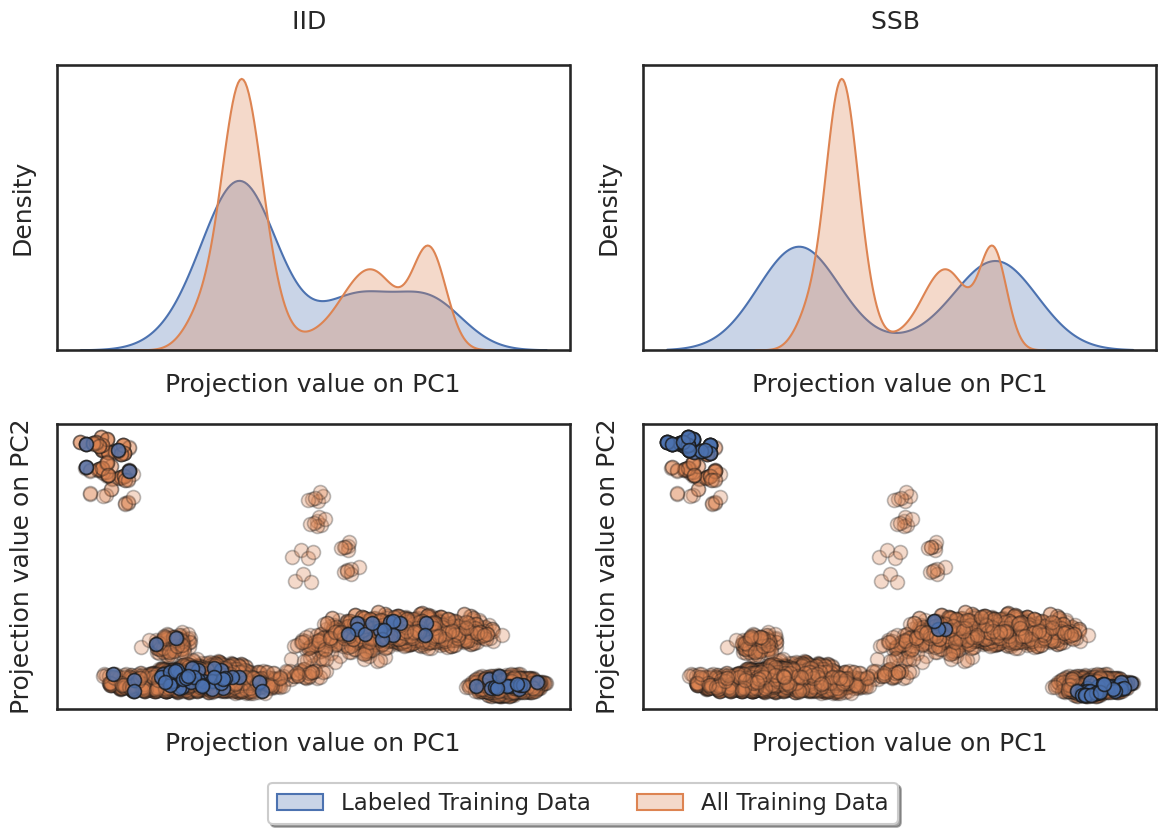

In [6]:
## Reduced size
dataset_name = "mushrooms"
num_lab_per_class = 40
verbose = True
figsize = (12, 8)
save = True
path = "figures"
filename = f"sample_selection_bias_plot.{format}"
dpi = 100
format = "pdf"
visualization(
    dataset_name=dataset_name,
    num_lab_per_class=num_lab_per_class,
    verbose=verbose,
    figsize=figsize,
    save=save,
    path=path,
    filename=filename,
    dpi=dpi,
    format=format,
)